    
# The Taxi Problem
<p align="center">
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6e/Taxi_in_New_York_City.jpg" alt="Charging bull" style="width:70%; border:0;">
</p>


Description from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition" by Tom Dietterich ([Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py))

## Description
There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

Map:
```
    +---------+,
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+
```
    
## Actions
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

## Observations
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states. Each state space is represented by the tuple: (taxi_row, taxi_col, passenger_location, destination). An observation is an integer that encodes the corresponding state. The state tuple can then be decoded with the "decode" method.

Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

## Info
``step`` and ``reset()`` will return an info dictionary that contains "p" and "action_mask" containing the probability that the state is taken and a mask of what actions will result in a change of state to speed up training.
As Taxi's initial state is a stochastic, the "p" key represents the probability of the
transition however this value is currently bugged being 1.0, this will be fixed soon.
As the steps are deterministic, "p" represents the probability of the transition which is always 1.0
For some cases, taking an action will have no effect on the state of the agent.
In v0.25.0, ``info["action_mask"]`` contains a np.ndarray for each of the action specifying
if the action will change the state.
To sample a modifying action, use ``action = env.action_space.sample(info["action_mask"])``
Or with a Q-value based algorithm ``action = np.argmax(q_values[obs, np.where(info["action_mask"] == 1)[0]])``.

## Rewards
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10  executing "pickup" and "drop-off" actions illegally.


# Sources for this notebook
OpenAI Gym Taxi environment: ([Github source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py)) <br>
Q-learning algorithm: [LearningDataSci](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

## Install and import libraries

In [ ]:
"""Install libraries (outcomment commands by removing # and run cell)"""
#!pip install cmake 'gym[atari]' scipy

'Install libraries (outcomment commands by removing # and run cell)'

In [ ]:
"""Import libraries"""
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

## General functions

In [ ]:
def run_animation(experience_buffer, time_lag=0.05):
    """Function to run animation"""
    time_lag = time_lag  # Delay (in s) between frames - increased for better visibility
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pauze animation
        sleep(time_lag)

In [ ]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 30  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def plot_training_results(cum_rewards, total_epochs, algo_name="Agent"):
    """
    Generates interactive plots for training rewards and epochs.
    Args:
        cum_rewards: Array of cumulative rewards per episode
        total_epochs: Array of steps/epochs per episode
        algo_name: String name for the plot titles (e.g., "Q-Learning", "SARSA")
    """
    # Calculate moving average for smoother trend
    window_size = 100
    # Guard against short runs
    ma_rewards = np.convolve(cum_rewards, np.ones(window_size)/window_size, mode='valid') if len(cum_rewards) >= window_size else cum_rewards
    ma_epochs = np.convolve(total_epochs, np.ones(window_size)/window_size, mode='valid') if len(total_epochs) >= window_size else total_epochs

    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=(f'Reward per Episode ({algo_name})', f'Epochs per Episode ({algo_name})'),
        vertical_spacing=0.12
    )

    # Reward per episode
    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(cum_rewards) + 1)),
            y=cum_rewards,
            mode='lines',
            name='Reward per Episode',
            line=dict(color='blue', width=1),
            opacity=0.6,
            hovertemplate='<b>Episode:</b> %{x}<br><b>Reward:</b> %{y:.2f}<extra></extra>'
        ),
        row=1, col=1
    )

    # Reward moving average
    fig.add_trace(
        go.Scatter(
            x=list(range(window_size if len(cum_rewards) >= window_size else 1, len(cum_rewards) + 1)),
            y=ma_rewards,
            mode='lines',
            name=f'Moving Average ({window_size} eps)',
            line=dict(color='red', width=2),
            hovertemplate='<b>Episode:</b> %{x}<br><b>Avg Reward:</b> %{y:.2f}<extra></extra>'
        ),
        row=1, col=1
    )

    # Epochs per episode
    fig.add_trace(
        go.Scatter(
            x=list(range(1, len(total_epochs) + 1)),
            y=total_epochs,
            mode='lines',
            name='Epochs per Episode',
            line=dict(color='green', width=1),
            opacity=0.6,
            hovertemplate='<b>Episode:</b> %{x}<br><b>Epochs:</b> %{y:.0f}<extra></extra>'
        ),
        row=2, col=1
    )

    # Epochs moving average
    fig.add_trace(
        go.Scatter(
            x=list(range(window_size if len(total_epochs) >= window_size else 1, len(total_epochs) + 1)),
            y=ma_epochs,
            mode='lines',
            name=f'Moving Average ({window_size} eps)',
            line=dict(color='orange', width=2),
            hovertemplate='<b>Episode:</b> %{x}<br><b>Avg Epochs:</b> %{y:.2f}<extra></extra>'
        ),
        row=2, col=1
    )

    # Layout tweaks
    fig.update_xaxes(title_text="Episode", row=1, col=1)
    fig.update_xaxes(title_text="Episode", row=2, col=1)
    fig.update_yaxes(title_text="Reward", row=1, col=1)
    fig.update_yaxes(title_text="Number of Epochs", row=2, col=1)

    fig.update_layout(
        height=800,
        showlegend=True,
        title_text=f"{algo_name} Training Progress (Interactive)",
        hovermode='closest'
    )

    fig.show()
    print("\nTip: Use the Plotly toolbar to zoom, pan, and hover. Double-click to reset view.")

## Environment initialization

In [ ]:
pip install "gymnasium[toy-text]"

State space: Discrete(500)
Action space: Discrete(6)
State: 164
Action: 3
Action mask: [1 1 1 0 0 0]
Reward: -1


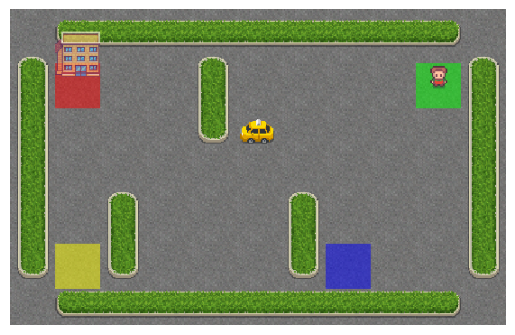

In [16]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation

"""Initialize and validate the environment"""
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, info = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

# Sample random action
action = env.action_space.sample(info["action_mask"])
next_state, reward, done, _, info = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(info["action_mask"]))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

# Simulation with random agent

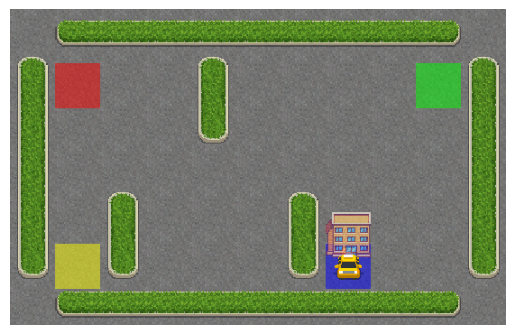

Episode: 1/1
Epoch: 144/144
State: 475
Action: 5
Reward: -565
# epochs: 145
# failed drop-offs: 49
# successful drop-offs: 1


In [17]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
num_successful_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Sample random action
    action = env.action_space.sample()
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1
    if reward == 20:
        num_successful_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))
print("# successful drop-offs: {}".format(num_successful_dropoffs))

## Training the agent with Q learning

In [29]:
import time

"""Training the agent"""
# Start timer
start_time = time.time()

q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

# Output for plots
q_cum_rewards = np.zeros([num_episodes])
q_total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    # Reset environment
    state, info = env.reset()
    epoch = 0
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Sample random action (exploration)
        else:
            action = np.argmax(q_table[state]) # Select best known action (exploitation)

        next_state, reward, done, _ , info = env.step(action)

        cum_reward += reward

        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)

        q_table[state, action] = new_q_value

        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1

        q_total_epochs[episode-1] = epoch
        q_cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode #: {episode}")

# End timer
end_time = time.time()
q_duration = end_time - start_time

print("\n")
print("===Q-Learning Training completed.===\n")
print(f"Total Training Time: {q_duration:.2f} seconds")

plot_training_results(q_cum_rewards, q_total_epochs, "Q-Learning")

Episode #: 10000


===Q-Learning Training completed.===

Total Training Time: 7.96 seconds



Tip: Use the Plotly toolbar to zoom, pan, and hover. Double-click to reset view.


## Simulation with Trained Agent
Compare the trained agent's behavior with the random agent from earlier.

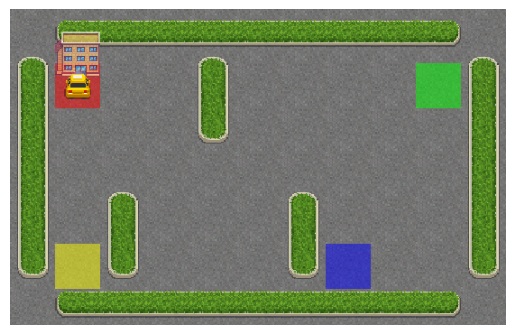

Episode: 10/10
Epoch: 13/13
State: 0
Action: 5
Reward: 7

Episode 10 Results:
  Epochs: 14
  Failed drop-offs: 0
  Successful drop-offs: 1
  Total reward: 7

=== OVERALL TRAINED AGENT RESULTS ===
Total episodes: 10
Average epochs per episode: 13.60
Average failed drop-offs per episode: 0.00
Average successful drop-offs per episode: 1.00
Average reward per episode: 7.40
Total reward: 74


In [33]:
"""Simulation with trained agent - see the learned behavior"""
num_test_episodes = 10

total_epochs = 0
total_failed_dropoffs = 0
total_successful_dropoffs = 0
total_reward = 0

for test_episode in range(1, num_test_episodes + 1):
    epoch = 0
    num_failed_dropoffs = 0
    num_successful_dropoffs = 0
    experience_buffer = []
    cum_reward = 0

    done = False
    state, info = env.reset()

    while not done:
        # Use the learned Q-table to select the best action
        action = np.argmax(q_table[state])

        state, reward, done, _, _ = env.step(action)
        cum_reward += reward

        # Store experience in dictionary
        experience_buffer.append({
            "frame": env.render(),
            "episode": test_episode,
            "epoch": epoch,
            "state": state,
            "action": action,
            "reward": cum_reward,
            }
        )

        if reward == -10:
            num_failed_dropoffs += 1
        if reward == 20:
            num_successful_dropoffs += 1

        epoch += 1

    # Accumulate statistics
    total_epochs += epoch
    total_failed_dropoffs += num_failed_dropoffs
    total_successful_dropoffs += num_successful_dropoffs
    total_reward += cum_reward

    # Run animation for this episode
    print(f"\n{'='*50}")
    print(f"EPISODE {test_episode}/{num_test_episodes}")
    print(f"{'='*50}")
    run_animation(experience_buffer, time_lag=0.1)

    # Print episode summary
    print(f"\nEpisode {test_episode} Results:")
    print(f"  Epochs: {epoch}")
    print(f"  Failed drop-offs: {num_failed_dropoffs}")
    print(f"  Successful drop-offs: {num_successful_dropoffs}")
    print(f"  Total reward: {cum_reward}")

# Print overall summary
print(f"\n{'='*50}")
print("=== OVERALL TRAINED AGENT RESULTS ===")
print(f"{'='*50}")
print(f"Total episodes: {num_test_episodes}")
print(f"Average epochs per episode: {total_epochs / num_test_episodes:.2f}")
print(f"Average failed drop-offs per episode: {total_failed_dropoffs / num_test_episodes:.2f}")
print(f"Average successful drop-offs per episode: {total_successful_dropoffs / num_test_episodes:.2f}")
print(f"Average reward per episode: {total_reward / num_test_episodes:.2f}")
print(f"Total reward: {total_reward}")

# SARSA Algorithm

SARSA (State-Action-Reward-State-Action) is an on-policy TD control algorithm. Unlike Q-learning which uses the maximum Q-value for the next state (off-policy), SARSA uses the actual action that will be taken in the next state (on-policy).

**SARSA Update Rule:**
Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]

Where a' is the actual next action chosen by the policy (not necessarily the max).

## Training the agent with SARSA

In [30]:
"""Training the agent using SARSA"""
# Start timer
start_time = time.time()

sarsa_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

# Output for plots
sarsa_cum_rewards = np.zeros([num_episodes])
sarsa_total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    # Reset environment
    state, info = env.reset()
    epoch = 0
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    # Choose initial action using epsilon-greedy policy
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()  # Explore
    else:
        action = np.argmax(sarsa_table[state])  # Exploit

    while not done:
        # Take action and observe next state and reward
        next_state, reward, done, _, info = env.step(action)
        cum_reward += reward

        # Choose next action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample()  # Explore
        else:
            next_action = np.argmax(sarsa_table[next_state])  # Exploit

        # SARSA update
        old_value = sarsa_table[state, action]
        next_value = sarsa_table[next_state, next_action]

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_value)

        sarsa_table[state, action] = new_value

        if reward == -10:
            num_failed_dropoffs += 1

        # Move to next state and action
        state = next_state
        action = next_action
        epoch += 1

        sarsa_total_epochs[episode-1] = epoch
        sarsa_cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode #: {episode}")

# End timer
end_time = time.time()
sarsa_duration = end_time - start_time

print("\n")
print("===SARSA Training completed.===\n")
print(f"Total Training Time: {sarsa_duration:.2f} seconds")

plot_training_results(sarsa_cum_rewards, sarsa_total_epochs, "SARSA")

Episode #: 10000


===SARSA Training completed.===

Total Training Time: 6.14 seconds



Tip: Use the Plotly toolbar to zoom, pan, and hover. Double-click to reset view.


## Simulation with SARSA Trained Agent

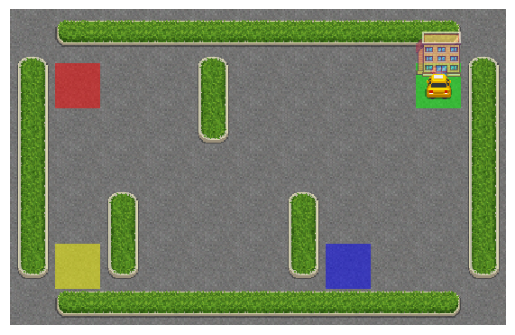

Episode: 10/10
Epoch: 9/9
State: 85
Action: 5
Reward: 11

Episode 10 Results:
  Epochs: 10
  Failed drop-offs: 0
  Successful drop-offs: 1
  Total reward: 11

=== OVERALL SARSA AGENT RESULTS ===
Total episodes: 10
Average epochs per episode: 12.60
Average failed drop-offs per episode: 0.00
Average successful drop-offs per episode: 1.00
Average reward per episode: 8.40
Total reward: 84


In [26]:
"""Simulation with SARSA trained agent"""
num_test_episodes = 10

total_epochs = 0
total_failed_dropoffs = 0
total_successful_dropoffs = 0
total_reward = 0

for test_episode in range(1, num_test_episodes + 1):
    epoch = 0
    num_failed_dropoffs = 0
    num_successful_dropoffs = 0
    experience_buffer = []
    cum_reward = 0

    done = False
    state, info = env.reset()

    while not done:
        # Use the learned SARSA table to select the best action
        action = np.argmax(sarsa_table[state])

        state, reward, done, _, _ = env.step(action)
        cum_reward += reward

        # Store experience in dictionary
        experience_buffer.append({
            "frame": env.render(),
            "episode": test_episode,
            "epoch": epoch,
            "state": state,
            "action": action,
            "reward": cum_reward,
            }
        )

        if reward == -10:
            num_failed_dropoffs += 1
        if reward == 20:
            num_successful_dropoffs += 1

        epoch += 1

    # Accumulate statistics
    total_epochs += epoch
    total_failed_dropoffs += num_failed_dropoffs
    total_successful_dropoffs += num_successful_dropoffs
    total_reward += cum_reward

    # Run animation for this episode
    print(f"\n{'='*50}")
    print(f"SARSA EPISODE {test_episode}/{num_test_episodes}")
    print(f"{'='*50}")
    run_animation(experience_buffer, time_lag=0.1)

    # Print episode summary
    print(f"\nEpisode {test_episode} Results:")
    print(f"  Epochs: {epoch}")
    print(f"  Failed drop-offs: {num_failed_dropoffs}")
    print(f"  Successful drop-offs: {num_successful_dropoffs}")
    print(f"  Total reward: {cum_reward}")

# Print overall summary
print(f"\n{'='*50}")
print("=== OVERALL SARSA AGENT RESULTS ===")
print(f"{'='*50}")
print(f"Total episodes: {num_test_episodes}")
print(f"Average epochs per episode: {total_epochs / num_test_episodes:.2f}")
print(f"Average failed drop-offs per episode: {total_failed_dropoffs / num_test_episodes:.2f}")
print(f"Average successful drop-offs per episode: {total_successful_dropoffs / num_test_episodes:.2f}")
print(f"Average reward per episode: {total_reward / num_test_episodes:.2f}")
print(f"Total reward: {total_reward}")

## Comparison: Q-Learning vs SARSA

In [28]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def plot_algorithm_comparison(q_rewards, sarsa_rewards, q_epochs, sarsa_epochs):
    """
    Overlays the Moving Averages of Q-Learning and SARSA for direct comparison.
    """
    window_size = 100

    # Calculate Moving Averages (MA) for Q-Learning
    q_ma_rewards = np.convolve(q_rewards, np.ones(window_size)/window_size, mode='valid')
    q_ma_epochs = np.convolve(q_epochs, np.ones(window_size)/window_size, mode='valid')

    # Calculate Moving Averages (MA) for SARSA
    s_ma_rewards = np.convolve(sarsa_rewards, np.ones(window_size)/window_size, mode='valid')
    s_ma_epochs = np.convolve(sarsa_epochs, np.ones(window_size)/window_size, mode='valid')

    # Create Subplots
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=('Comparison: Average Reward per Episode', 'Comparison: Average Epochs (Steps) per Episode'),
        vertical_spacing=0.15
    )

    # --- PLOT 1: REWARDS COMPARISON ---
    # Q-Learning Reward MA
    fig.add_trace(
        go.Scatter(
            x=list(range(window_size, len(q_rewards) + 1)),
            y=q_ma_rewards,
            mode='lines',
            name='Q-Learning (Avg Reward)',
            line=dict(color='blue', width=2),
            hovertemplate='<b>Q-Learning</b><br>Episode: %{x}<br>Avg Reward: %{y:.2f}<extra></extra>'
        ),
        row=1, col=1
    )

    # SARSA Reward MA
    fig.add_trace(
        go.Scatter(
            x=list(range(window_size, len(sarsa_rewards) + 1)),
            y=s_ma_rewards,
            mode='lines',
            name='SARSA (Avg Reward)',
            line=dict(color='orange', width=2),
            hovertemplate='<b>SARSA</b><br>Episode: %{x}<br>Avg Reward: %{y:.2f}<extra></extra>'
        ),
        row=1, col=1
    )

    # --- PLOT 2: EPOCHS COMPARISON ---
    # Q-Learning Epochs MA
    fig.add_trace(
        go.Scatter(
            x=list(range(window_size, len(q_epochs) + 1)),
            y=q_ma_epochs,
            mode='lines',
            name='Q-Learning (Avg Epochs)',
            line=dict(color='blue', width=2, dash='dot'), # Dotted line for distinction
            hovertemplate='<b>Q-Learning</b><br>Episode: %{x}<br>Avg Epochs: %{y:.1f}<extra></extra>'
        ),
        row=2, col=1
    )

    # SARSA Epochs MA
    fig.add_trace(
        go.Scatter(
            x=list(range(window_size, len(sarsa_epochs) + 1)),
            y=s_ma_epochs,
            mode='lines',
            name='SARSA (Avg Epochs)',
            line=dict(color='orange', width=2, dash='dot'),
            hovertemplate='<b>SARSA</b><br>Episode: %{x}<br>Avg Epochs: %{y:.1f}<extra></extra>'
        ),
        row=2, col=1
    )

    # Layout Updates
    fig.update_layout(
        height=900,
        title_text="Algorithm Comparison: Q-Learning vs SARSA",
        hovermode="x unified", # Shows both values when you hover over an x-coordinate
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    fig.update_xaxes(title_text="Episode", row=1, col=1)
    fig.update_xaxes(title_text="Episode", row=2, col=1)
    fig.update_yaxes(title_text="Moving Avg Reward", row=1, col=1)
    fig.update_yaxes(title_text="Moving Avg Epochs", row=2, col=1)

    fig.show()

# Run the comparison
# Ensure you have run the Training Blocks (Block 2 and Block 3) before running this!
plot_algorithm_comparison(q_cum_rewards, sarsa_cum_rewards, q_total_epochs, sarsa_total_epochs)

In [32]:
import pandas as pd
import numpy as np
from IPython.display import display

def compare_results_table(q_rewards, sarsa_rewards, q_eps, sarsa_eps, q_time, s_time):
    # Calculate statistics based on the last 100 episodes (convergence performance)
    last_n = 100

    data = {
        "Metric": [
            "Total Training Time (sec)",
            f"Avg Reward (Last {last_n} eps)",
            f"Std Dev Reward (Last {last_n} eps)",
            f"Avg Epochs/Steps (Last {last_n} eps)",
            "Max Reward Achieved"
        ],
        "Q-Learning": [
            f"{q_time:.2f}",
            f"{np.mean(q_rewards[-last_n:]):.2f}",
            f"{np.std(q_rewards[-last_n:]):.2f}",
            f"{np.mean(q_eps[-last_n:]):.2f}",
            f"{np.max(q_rewards):.2f}"
        ],
        "SARSA": [
            f"{s_time:.2f}",
            f"{np.mean(sarsa_rewards[-last_n:]):.2f}",
            f"{np.std(sarsa_rewards[-last_n:]):.2f}",
            f"{np.mean(sarsa_eps[-last_n:]):.2f}",
            f"{np.max(sarsa_rewards):.2f}"
        ]
    }

    df = pd.DataFrame(data)

    # Display standard pandas dataframe
    display(df)

# Run the table generation
# Checks if duration variables exist
try:
    q_dur = q_duration
    s_dur = sarsa_duration
except NameError:
    print("Warning: Training duration variables not found. Using placeholders.")
    q_dur = 0.0
    s_dur = 0.0

compare_results_table(q_cum_rewards, sarsa_cum_rewards, q_total_epochs, sarsa_total_epochs, q_dur, s_dur)

,Metric,Q-Learning,SARSA
0,Total Training Time (sec),7.96,6.14
1,Avg Reward (Last 100 eps),0.95,1.90
2,Std Dev Reward (Last 100 eps),7.52,8.12
3,Avg Epochs/Steps (Last 100 eps),15.19,15.05
4,Max Reward Achieved,15.00,15.00
